# **Today you are a MLE at Uber Perception Stack Team!**
## Your team is developing new software around automated detection of cars, pedestrians at all conditions for autonomous drive. One major bottleneck is data collection under severe weather conditions, especially capturing night-time images. So your task is to generate night time equivalent images from daytime images, such that you have access to some outdoor images acquired at night and some at day, but no pairwise images are available.

### *Pairwise image means*: same view available in Day and Night times.


In this assignment we implement CycleGAN using Keras with the intention to transform Day time to night time images for Autonomous Drive like in:
https://github.com/simontomaskarlsson/CycleGAN-Keras

This work is an adaptation of the blog in: https://machinelearningmastery.com/how-to-develop-cyclegan-models-from-scratch-with-keras/

#Lets start with the concepts of CycleGAN:

The model architecture is comprised of two generator models: one generator (Generator-A) for generating images for the first domain (Domain-A) and the second generator (Generator-B) for generating images for the second domain (Domain-B). Lets consider here, **Domain-A: Daytime**, **Domain-B: Nighttime**

* Generator-A -> Domain-A
* Generator-B -> Domain-B

The generator models perform image translation, meaning that the image generation process is conditional on an input image, specifically an image from the other domain. Generator-A takes an image from Domain-B as input and Generator-B takes an image from Domain-A as input.

* Domain-B -> Generator-A -> Domain-A
* Domain-A -> Generator-B -> Domain-B
Each generator has a corresponding discriminator model.

The first discriminator model (Discriminator-A) takes real images from Domain-A (daytime images) and generated images from Generator-A and predicts whether they are real or fake. The second discriminator model (Discriminator-B) takes real images from Domain-B (night-time images) and generated images from Generator-B and predicts whether they are real or fake.

* Domain-A -> Discriminator-A -> [Real/Fake]
* Domain-B -> Generator-A -> Discriminator-A -> [Real/Fake]
* Domain-B -> Discriminator-B -> [Real/Fake]
* Domain-A -> Generator-B -> Discriminator-B -> [Real/Fake]
The discriminator and generator models are trained in an adversarial zero-sum process, like normal GAN models.

The generators learn to better fool the discriminators and the discriminators learn to better detect fake images. Together, the models find an equilibrium during the training process.

Passing an image through both generators is called a cycle. Together, each pair of generator models are trained to better reproduce the original source image, referred to as cycle consistency.

* Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B
* Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A


**Our goal is to train such a 2 set Generator-Discriminator pair, to finally generate night-time images from day-time ones and quantify performance...**



# Task 0: Install libraries and load data

In [1]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 706kB 23.6MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pwd

/content/drive/My Drive/Colab Notebooks/Week 9


In [11]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/Colab Notebooks/Week 9/training/')
!ls

day  night


## **Task 1 [Instructor Led]:  Design functions for Generator-Discriminator pairs**: 


Step 1: Lets start by stepwise defining all libraries and functions needed to generate the model and pre-process the data

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 128, 128, 128)     131200    
_________________________________________________________________
instance_normalization_28 (I (None, 128, 128, 128)     256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 128, 256)     5245

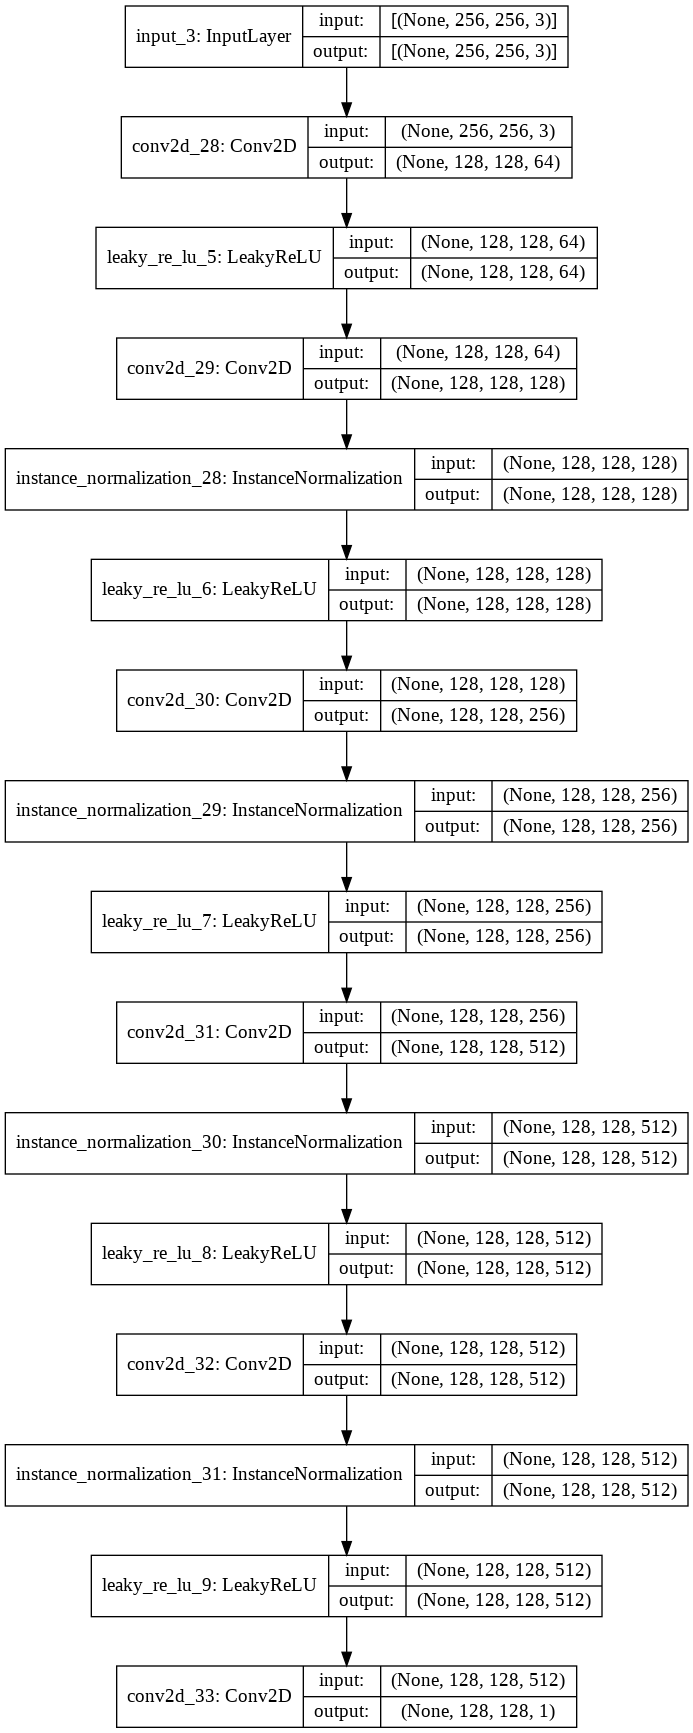

In [12]:
#Step 1: Defining a Patchgan discriminator model
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d) #Stride reduces shape of image
	# C128
	d = Conv2D(128, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# define image shape
image_shape = (256,256,3)
# create the model
model = define_discriminator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

#############Note the final shape of the image patch=Patch size########################

In [13]:
#Step 2: Generator Model
# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization()(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization()(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [14]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3), n_resnet=9):
	# weight initialization
  init = RandomNormal(stddev=0.02)
  # image input
  in_image = Input(shape=image_shape)
  # c7s1-64
  g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # d128
  g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # d256
  g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # R256
  for _ in range(n_resnet):
    g = resnet_block(256, g)
  # u128
  g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # u64
  g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # c7s1-3
  g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  out_image = Activation('sigmoid')(g)
  # define model
  model = Model(in_image, out_image)
  return model

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 256, 256, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
instance_normalization_32 (Inst (None, 256, 256, 64) 128         conv2d_34[0][0]                  
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 256, 256, 64) 0           instance_normalization_32[0][0]  
____________________________________________________________________________________________

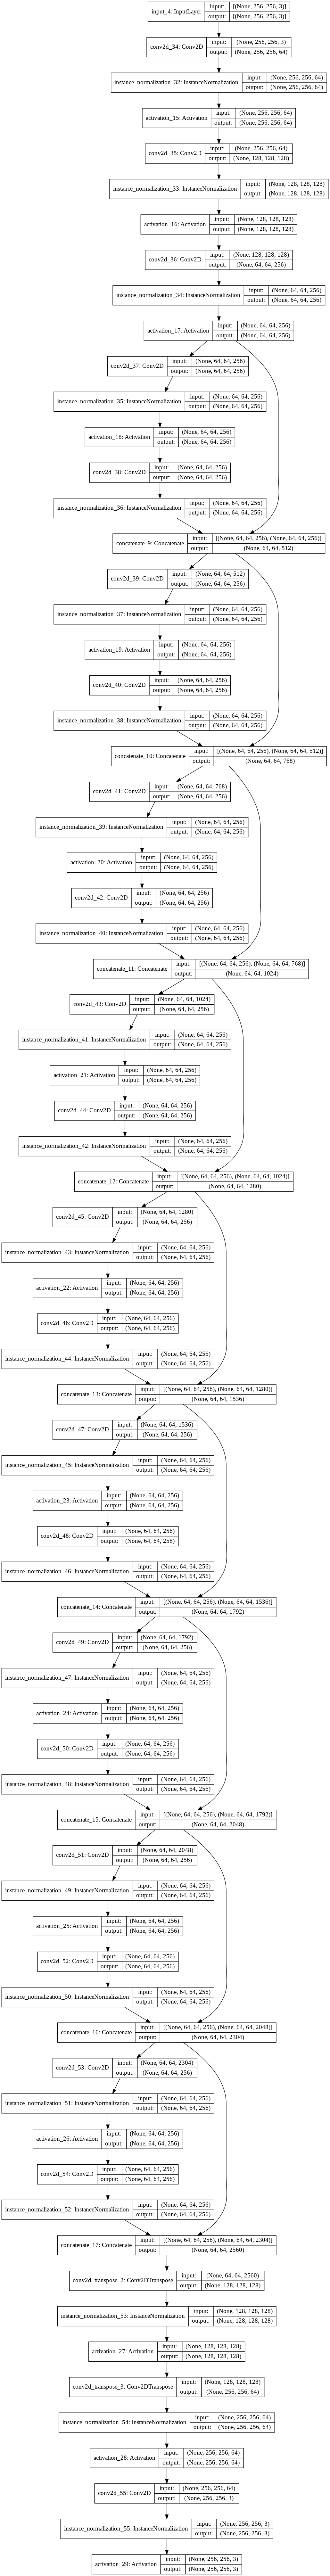

In [15]:
# create the model
model = define_generator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
# Step 3: Define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model
  ############Notice no cross enytropy loss used here######################################

In [17]:
#Step 4: All definitions together
# input shape
image_shape = (256,256,3)
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [18]:
#Step 5: Helper functions to select real samples and generate fake samples

from random import randint
#write a function to generate 'n_samples' random integers in range (start,stop)
def randnums(start,stop,n_samples):
  ix=[]
  for i in range(n_samples):
    ix.append(randint(start,stop))
  ix=np.array(ix)
  return ix

In [19]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
# choose random instances
  ix = randnums(0, dataset.shape[0]-1, n_samples)
  # retrieve selected images
  #print(ix,np.shape(dataset))
  X = dataset[ix]
  # generate 'real' class labels (1)
  y = np.ones((n_samples, patch_shape, patch_shape, 1))
  return X, y


In [20]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [21]:
# update image pool for fake images
import random
def update_image_pool(pool, images, max_size=50):
  selected = list()
  for image in images:
    if len(pool) < max_size:
    # stock the pool
      pool.append(image)
      selected.append(image)
    elif random.random() < 0.5:
      # use image, but don't add it to the pool
      selected.append(image)
    else:
      # replace an existing image and use replaced image
      ix = randint(0, len(pool)-1)
      print(ix,np.shape(pool))
      selected.append(pool[ix])
      pool[ix] = image
  return np.asarray(selected)


# All helper functions are now defined, now lets begin training!

Order of tasks:
* Update Generator-B (A->B)
* Update Discriminator-B
* Update Generator-A (B->A)
* Update Discriminator-A

In [22]:
# train function for the cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA,trainB):

  # define properties of the training run
  n_epochs, n_batch, = 10, 1 #Keep n_batch as 1 for per image training. n_epochs can be changed
  # determine the output square shape of the discriminator
  n_patch = d_model_A.output_shape[1] #Notice n_patch depends on the discriminator output image size. This parameter can be changed for improvement.
  
  # prepare image pool for fakes
  poolA, poolB = list(), list()
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  print(n_steps)
  for i in range(n_steps):
  # select a batch of real samples
    X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
    X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
    
    # generate a batch of fake samples
    X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
    X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
    # update fakes from pool
    X_fakeA = update_image_pool(poolA, X_fakeA)
    X_fakeB = update_image_pool(poolB, X_fakeB)
    # update generator B->A via adversarial and cycle loss
    g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
    # update discriminator for A -> [real/fake]
    dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
    dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
    # update generator A->B via adversarial and cycle loss
    g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
    # update discriminator for B -> [real/fake]
    dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
    dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
    # summarize performance
    print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
  return(g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA)

# **Task 2: Train the model from scratch** 
# Load the images DomainA-> Day, DomainB-> Night. 
You may use as many as 50 images to train the generator. More images will need more epochs and more train time. So limit training images to 30-50 images from each domain.
# Call the train function to train on the images


In [ ]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image
import cv2






  0%|          | 0/50 [00:00<?, ?it/s]




  4%|▍         | 2/50 [00:00<00:04, 10.75it/s]




 18%|█▊        | 9/50 [00:01<00:04,  9.28it/s]




 22%|██▏       | 11/50 [00:02<00:08,  4.42it/s]




 28%|██▊       | 14/50 [00:03<00:09,  3.88it/s]




 36%|███▌      | 18/50 [00:07<00:15,  2.09it/s]




 44%|████▍     | 22/50 [00:09<00:13,  2.04it/s]




 56%|█████▌    | 28/50 [00:11<00:09,  2.27it/s]




 62%|██████▏   | 31/50 [00:13<00:09,  1.95it/s]




 72%|███████▏  | 36/50 [00:15<00:06,  2.10it/s]




 80%|████████  | 40/50 [00:17<00:04,  2.07it/s]




 84%|████████▍ | 42/50 [00:24<00:11,  1.39s/it]




100%|██████████| 50/50 [00:34<00:00,  1.46it/s]





  0%|          | 0/50 [00:00<?, ?it/s]




  2%|▏         | 1/50 [00:09<08:08,  9.97s/it]




  4%|▍         | 2/50 [00:14<06:47,  8.48s/it]




  8%|▊         | 4/50 [00:24<05:41,  7.43s/it]




 10%|█         | 5/50 [00:44<08:24, 11.20s/it]




 12%|█▏        | 6/50 [00:49<06:51,  9.35s/it]




 18%|█▊        | 9/50 [00:51<04

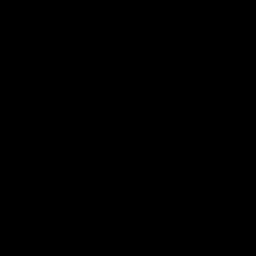

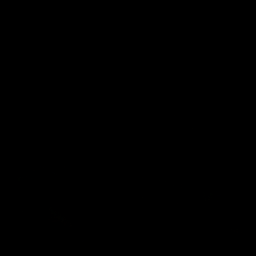

(50, 256, 256, 3)
(50, 256, 256, 3)


In [35]:
# load a daytime images as trainA, nighttime images as train B (numpy lists)
############START CODE HERE##################################3
import cv2
import numpy as np
from tqdm import tqdm
from google.colab.patches import cv2_imshow
NUM_DAY = 50
NUM_NIGHT = 50
trainA = np.zeros((NUM_DAY, *image_shape), dtype=np.float32)
image_filenames = [os.path.join('day', filename) for filename in os.listdir('day') if filename.endswith('.jpg')]
np.random.shuffle(image_filenames)
image_filenames = image_filenames[:NUM_DAY]
for i, filename in enumerate(tqdm(image_filenames)):
    img_arr = cv2.imread(filename)
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    img_arr = cv2.resize(img_arr, image_shape[:2])
    img_arr = img_arr.astype(np.float32)
    img_arr /= 255.
    trainA[i] = img_arr
trainB = np.zeros((NUM_NIGHT, *image_shape), dtype=np.float32)
image_filenames = [os.path.join('night', filename) for filename in os.listdir('night') if filename.endswith('.jpg')]
np.random.shuffle(image_filenames)
image_filenames = image_filenames[:NUM_NIGHT]
for i, filename in enumerate(tqdm(image_filenames)):
    img_arr = cv2.imread(filename)
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    img_arr = cv2.resize(img_arr, image_shape[:2])
    img_arr = img_arr.astype(np.float32)
    img_arr /= 255.
    trainB[i] = img_arr
#################################################################



(50, 256, 256, 3)
(50, 256, 256, 3)


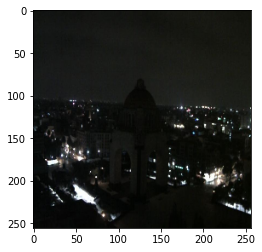

In [41]:
import matplotlib.pyplot as plt
plt.imshow(trainA[0])
plt.imshow(trainB[0])
print(trainA.shape)
print(trainB.shape)

# Next train the cycleGAN using the train function!

In [42]:
# train CycleGAN
############START CODE HERE##############################
#Call the function train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,trainA,trainB) and save the returned model
g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA = train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA, trainB)
g_model_AtoB.save('g_model_AtoB.h5')
g_model_BtoA.save('g_model_BtoA.h5')
c_model_AtoB.save('c_model_AtoB.h5')
c_model_BtoA.save('c_model_BtoA.h5')
#####################################################################

500
>1, dA[1.929,1.988] dB[1.550,2.808] g[10.248,10.295]
>2, dA[24.781,12.029] dB[12.511,2.479] g[26.012,28.862]
>3, dA[6.606,2.164] dB[3.395,5.894] g[8.513,11.969]
>4, dA[8.982,2.842] dB[1.250,6.418] g[10.324,13.080]
>5, dA[1.955,1.964] dB[1.140,5.008] g[10.060,9.197]
>6, dA[1.209,3.712] dB[1.299,3.021] g[10.339,10.572]
>7, dA[1.084,1.366] dB[0.901,2.611] g[12.246,9.070]
>8, dA[0.991,1.239] dB[0.543,0.772] g[7.507,7.621]
>9, dA[0.504,2.022] dB[0.368,0.597] g[9.383,9.180]
>10, dA[0.327,1.110] dB[0.393,0.894] g[6.235,6.604]
>11, dA[0.343,0.664] dB[0.243,0.355] g[8.812,7.611]
>12, dA[0.315,0.563] dB[0.287,0.314] g[9.019,8.406]
>13, dA[0.218,0.553] dB[0.194,0.239] g[8.900,8.685]
>14, dA[0.311,0.561] dB[0.207,0.254] g[6.679,6.608]
>15, dA[0.214,0.302] dB[0.178,0.144] g[9.515,8.837]
>16, dA[0.288,0.257] dB[0.225,0.158] g[8.433,7.620]
>17, dA[0.192,0.233] dB[0.194,0.149] g[6.211,6.056]
>18, dA[0.233,0.138] dB[0.227,0.146] g[9.128,8.192]
>19, dA[0.188,0.185] dB[0.166,0.169] g[6.984,6.704]
>20

# **Task 3**: Write a test function to generate fake images for the test set
### Create Day->Night, Night->Day. versions separately
### Visualize some images. What parameters would you change to improve?
Hint: Use the format of the train function to create the test function.

In [66]:
#Define a test function to generate day to night images
import matplotlib.pyplot as plt
def test(g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA, trainB):
###################START CODE HERE#############################
    n_batch = 1 
    n_patch = d_model_A.output_shape[1]
    for i in range(5):
        X_realA, _ = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, _ = generate_real_samples(trainB, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeA, _ = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, _ = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
    ###############################################################    
        ########First Day to night transformation
        print('Original Day Image is=\n')
        plt.imshow(np.squeeze(X_realA))
        plt.show()
        print('Fake Night image is=\n')
        plt.imshow(np.squeeze(X_fakeB))
        plt.show()
        #############Next Night to Day transformation
        print('Original Night Image is=\n')
        plt.imshow(np.squeeze(X_realB))
        plt.show()
        print('Fake Day image is=\n')
        plt.imshow(np.squeeze(X_fakeA))
        plt.show()


In [67]:
##Call the test function here test(.....)
#########START CODE HERE###############################
test(g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA, trainB)
########################################################

Output hidden; open in https://colab.research.google.com to view.

 # Notice a Banding around edges for the nighttime images. What paremeter would you change to reduce this banding?

 You would change the patch size.

# **Task 4**: Write a function to generate a full cycle Day->night->Day
[Hint]: Use the template in the train function to start with Day image and plot the cyclic day image generated.

# Write a function to quantify the error and similarity between the cycle generated image and original image (Day vs Generated Day)
[Hint]: Find mse and structural similarity between real and fake images to gauge the quality of cycleGAN.



In [61]:
from skimage.metrics import mean_squared_error
from skimage.metrics import structural_similarity
#Function to compute similarity in Cycle images
def similarity_real_fake(real, fake):
  ###################Start Code Here#######################################
  mse = mean_squared_error(real, fake)
  ssim = structural_similarity(real, fake, multichannel=True, gaussian_weights=True)
  return mse, ssim
  ################################################################

In [68]:
def test_Cycle(g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA, trainB):
    # write this function to call the similarity_real_fake function above and print it under each real->Generated image pair
    ##############START CODE HERE#####################################################
    n_batch = 1 
    n_patch = 64
    for i in range(5):
        X_realA, _ = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, _ = generate_real_samples(trainB, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeA, _ = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, _ = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        # reproduce the real samples
        X_reproduceA, _ = generate_fake_samples(g_model_BtoA, X_fakeB, n_patch)
        X_reproduceB, _ = generate_fake_samples(g_model_AtoB, X_fakeA, n_patch)

        ###############################################################    
        ########First Day to night transformation
        print('Original Day Image is=\n')
        plt.imshow(np.squeeze(X_realA))
        plt.show()
        print('Reproduced Day image is=\n')
        plt.imshow(np.squeeze(X_reproduceA))
        plt.show()
        mse, ssim = similarity_real_fake(np.squeeze(X_realA), np.squeeze(X_reproduceA))
        print('MSE = {0}, SSIM = {1}'.format(mse, ssim))
        #############Next Night to Day transformation
        print('Original Night Image is=\n')
        plt.imshow(np.squeeze(X_realB))
        plt.show()
        print('Reproduced Night image is=\n')
        plt.imshow(np.squeeze(X_reproduceB))
        plt.show()
        mse, ssim = similarity_real_fake(np.squeeze(X_realB), np.squeeze(X_reproduceB))
        print('MSE = {0}, SSIM = {1}'.format(mse, ssim))

  ###############################################################################


In [69]:
# Call the function test_Cycle(....)
test_Cycle(g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA, trainB)

Output hidden; open in https://colab.research.google.com to view.

# Comment on which domain transformation is better quality and some steps to improve performance.

Both day to night and night to day transformation have visible artifacts. The day to night images have patches of glare (perhaps trying to reproduce street lighting), and the night to day images can be blurry or otherwise lack detail. I would say that the night to day images look better qualitatively. We can improve performance by modifying the loss function with different weighting for each of the components.